## Running LAS

In [19]:
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from tools.util import load_pkl, dump_pkl
from systems.pacircle import PACircle

#Number of HCCH monomers
NCELLS = 16
#Number of HCCH monomers per fragment (1 --> 2C/fragment)
N_PER_FRAG = 1
DIST = 2.47

geom = PACircle(DIST,NCELLS,N_PER_FRAG,fn="logs/pacircle.log",basis="3-21g")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_()
las.ci = sign_control.fix_sign(las) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

#Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel()
civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0) #sign fixing
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

#MC-PDFT Integration (takes a while)
print("Computing MC-PDFT Energies...")
start = time.perf_counter()
from mrh.my_pyscf import mcpdft
mc = mcpdft.LASSI(lsi, 'tPBE', las.ncas_sub, las.nelecas_sub, states=list(range(len(energies_lassi))))
energies_lsipdft,_,_,_,_,_,_ = mc.kernel()
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")

#Save to disk
#Results from paper are saved in logs/ already
las_charges = util.las_charges(las)
data = {"energies_lassi":energies_lassi,
        "energies_lassipdft":energies_lsipdft,
        "civecs":civecs_lassi,
        "charges":las_charges,
        "nfrags":geom.nfrags,
        "dist":geom.dist,
        "mf_coeff":geom.mf_coeff,
        "mf_occ":geom.mf_occ,
        "mf_ene":geom.mf_ene,
       }
d = int(DIST*10)
data_name = f"logs/pa{NCELLS}_frag{N_PER_FRAG}_dist{d}_lsipdft"
dump_pkl(data,f"{data_name}.pkl")

## Plotting Band Structure

,LASSI-PDFT
IP,5.35
EA,2.12
GAP,3.23


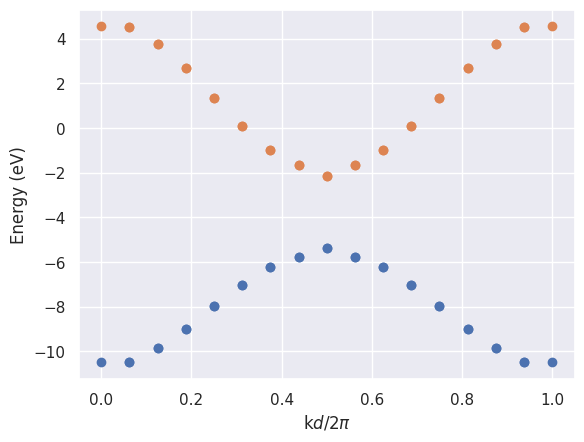

In [1]:
%load_ext autoreload
%autoreload 2

from tools import bandh
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools.util import load_pkl, LASdata
sns.set()

las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=True)
df = las.make_bands()
np.round(df,2)

,LASSI-PDFT
IP,5.34
EA,2.33
GAP,3.01


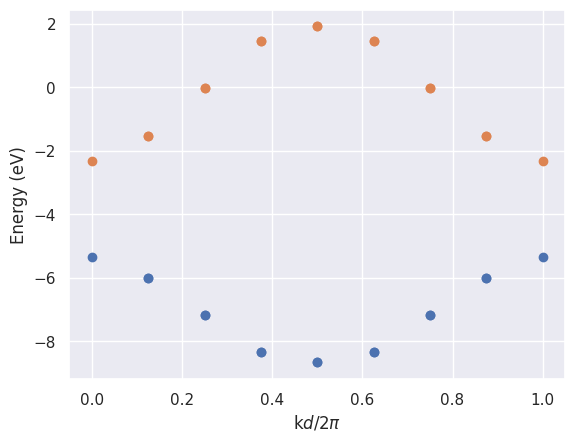

In [66]:
las = LASdata(pkl_fn="logs/pa16_frag2_dist24_lsipdft.pkl",pdft=True)
df = las.make_bands()
np.round(df,2)

[-1223.42 -1223.13 -1223.13 -1223.13 -1223.13 -1223.29 -1223.29 -1223.29
 -1223.29]


,LASSI-PDFT
IP,5.56
EA,2.17
GAP,3.39


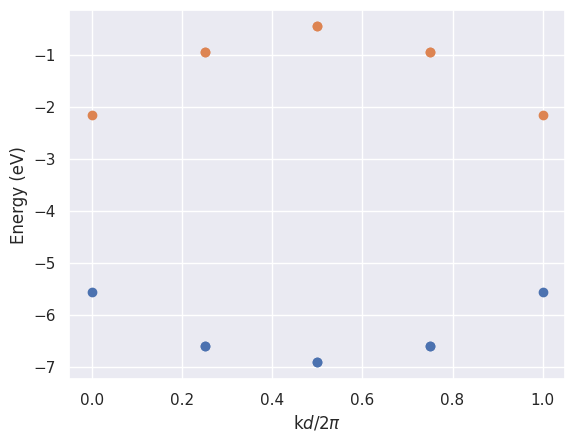

In [22]:
las = LASdata(pkl_fn="logs/pa16_frag4_dist24_lsipdft.pkl",pdft=True)
df = las.make_bands()
np.round(df,2)

## Adding Comparisons

In [47]:
from tools.util import LASdata, DMRGdata, PeriodicData
import pandas as pd
df = pd.DataFrame()

per = PeriodicData("logs/periodic_HF_frag2C_24_k16.csv")
df.loc["HF (2C)","IP"] = per.ip()
df.loc["HF (2C)","EA"] = per.ea()
# per = PeriodicData("logs/periodic_HF_frag4C_24_k16.csv")
# df.loc["HF (4C)","IP"] = per.ip()
# df.loc["HF (4C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_PBE_frag2C_24_k16.csv")
df.loc["PBE (2C)","IP"] = per.ip()
df.loc["PBE (2C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_PBE_frag4C_24_k16.csv")
df.loc["PBE (4C)","IP"] = per.ip()
df.loc["PBE (4C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_HSE06_frag2C_24_k16.csv")
df.loc["HSE06 (2C)","IP"] = per.ip()
df.loc["HSE06 (2C)","EA"] = per.ea()
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=True)
df.loc["LAS-PDFT (2C)","IP"] = las.ip()
df.loc["LAS-PDFT (2C)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/pa16_frag2_dist24_lsipdft.pkl",pdft=True)
df.loc["LAS-PDFT (4C)","IP"] = las.ip()
df.loc["LAS-PDFT (4C)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/pa16_frag4_dist24_lsipdft.pkl",pdft=True)
df.loc["LAS-PDFT (8C)","IP"] = las.ip()
df.loc["LAS-PDFT (8C)","EA"] = las.ea()
dmrg = DMRGdata("logs/pa16_d24_m500.csv",pdft=True)
df.loc["DMRG-PDFT (32C)","IP"] = dmrg.ip()
df.loc["DMRG-PDFT (32C)","EA"] = dmrg.ea()
df.loc["BNL*","IP"] = 5.87
df.loc["BNL*","EA"] = -(-5.87 + 3.77)
df["GAP"] = df["IP"] - df["EA"]
df = df.T
df = np.round(df,2)
df

 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


,HF (2C),PBE (2C),PBE (4C),HSE06 (2C),LAS-PDFT (2C),LAS-PDFT (4C),LAS-PDFT (8C),DMRG-PDFT (32C),BNL*
IP,5.68,3.73,3.73,4.08,5.35,5.34,5.56,5.28,5.87
EA,-0.79,2.85,2.85,2.65,2.12,2.33,2.17,2.60,2.10
GAP,6.47,0.89,0.89,1.44,3.23,3.01,3.39,2.68,3.77


 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


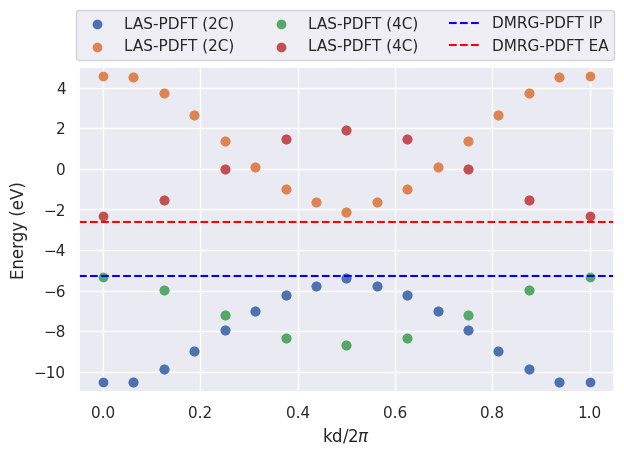

In [64]:
from tools.util import LASdata, DMRGdata, PeriodicData
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=True)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS-PDFT (2C)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS-PDFT (2C)")

las = LASdata(pkl_fn="logs/pa16_frag2_dist24_lsipdft.pkl",pdft=True)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS-PDFT (4C)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS-PDFT (4C)")

# las = LASdata(pkl_fn="logs/pa16_frag4_dist24_lsipdft.pkl",pdft=True)
# e,k = las.get_homo()
# plt.scatter(k,e,label="LAS-PDFT (8C)")
# e,k = las.get_lumo()
# plt.scatter(k,e,label="LAS-PDFT (8C)")

dmrg = DMRGdata("logs/pa16_d24_m500.csv")
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG-PDFT IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG-PDFT EA")

plt.legend(bbox_to_anchor=(1.015,1.2),ncols=3)
plt.ylim(-11,5)
# plt.ylim(-14,9)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.annotate("C",(0,6),fontsize=20)
plt.tight_layout()
plt.savefig("figures/pa32c_laspdft_band_structures.png",dpi=500)

 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


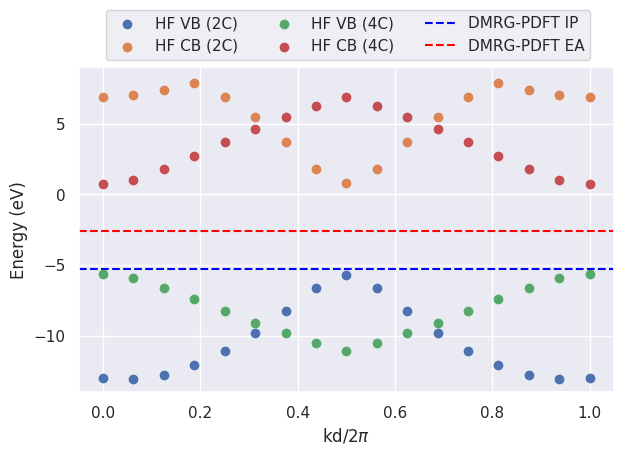

In [45]:
from tools.util import LASdata, DMRGdata, PeriodicData
per = PeriodicData("logs/periodic_HF_frag2C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label="HF VB (2C)")
e,k = per.get_lumo()
plt.scatter(k,e,label="HF CB (2C)")

per = PeriodicData("logs/periodic_HF_frag4C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label="HF VB (4C)")
e,k = per.get_lumo()
plt.scatter(k,e,label="HF CB (4C)")

dmrg = DMRGdata("logs/pa16_d24_m500.csv")
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG-PDFT IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG-PDFT EA")

plt.legend(bbox_to_anchor=(0.97,1.2),ncols=3)
plt.ylim(-14,9)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
# plt.annotate("D",(0,4),fontsize=20)
plt.tight_layout()
plt.savefig("figures/pa32c_hf_band_structures.png",dpi=500)

 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


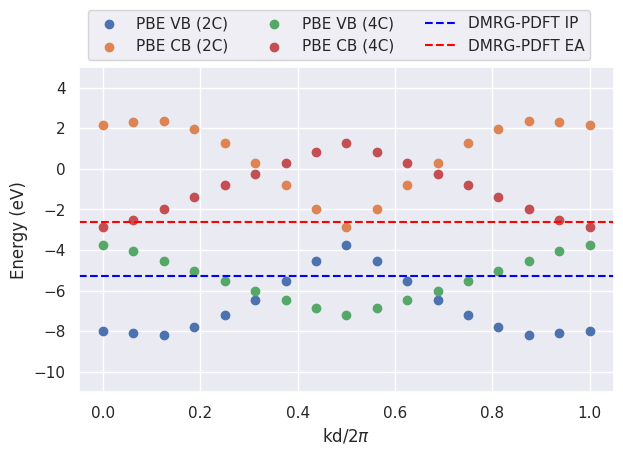

In [43]:
from tools.util import LASdata, DMRGdata, PeriodicData
fnal = "PBE"
per = PeriodicData(f"logs/periodic_{fnal}_frag2C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (2C)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (2C)")

fnal = "PBE"
per = PeriodicData(f"logs/periodic_{fnal}_frag4C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (4C)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (4C)")

dmrg = DMRGdata("logs/pa16_d24_m500.csv")
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG-PDFT IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG-PDFT EA")

plt.legend(bbox_to_anchor=(0.97,1.2),ncols=3)
plt.ylim(-11,5)
plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig(f"figures/pa32c_{fnal}_band_structures.png",dpi=500)

 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


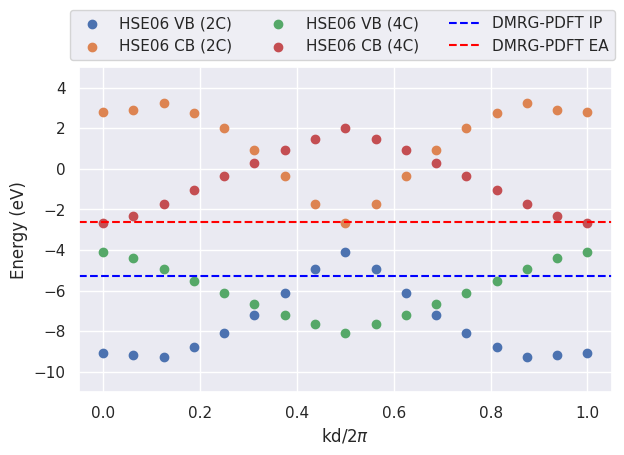

In [44]:
from tools.util import LASdata, DMRGdata, PeriodicData
fnal = "HSE06"
per = PeriodicData(f"logs/periodic_{fnal}_frag2C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (2C)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (2C)")

fnal = "HSE06"
per = PeriodicData(f"logs/periodic_{fnal}_frag4C_24_k16.csv")
e,k = per.get_homo()
plt.scatter(k,e,label=f"{fnal} VB (4C)")
e,k = per.get_lumo()
plt.scatter(k,e,label=f"{fnal} CB (4C)")

dmrg = DMRGdata("logs/pa16_d24_m500.csv")
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG-PDFT IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG-PDFT EA")

# plt.legend(bbox_to_anchor=(0.82,1.2),ncols=2)
plt.legend(bbox_to_anchor=(1.02,1.2),ncols=3)
plt.ylim(-11,5)
plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.tight_layout()
plt.savefig(f"figures/pa32c_{fnal}_band_structures.png",dpi=500)

## Hamiltonian Structure

[-1222.93 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54
 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54
 -1222.54 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66
 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66
 -1222.66]


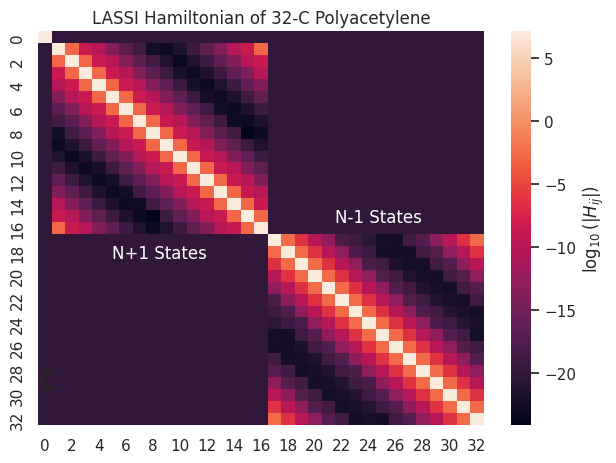

In [10]:
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=True)
H = las.make_h()
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
sns.heatmap(H,cbar_kws={'label': "$\log_{10}(|H_{ij}|)$"})
plt.title("LASSI Hamiltonian of 32-C Polyacetylene")
plt.annotate("N+1 States",(5.5,19),c="white")
plt.annotate("N-1 States",(22,16),c="white")
plt.annotate("C",(0,30),fontsize=20)
plt.tight_layout()
plt.savefig("figures/c32H.png",dpi=500)

[-1222.93 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54
 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54 -1222.54
 -1222.54 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66
 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66 -1222.66
 -1222.66]


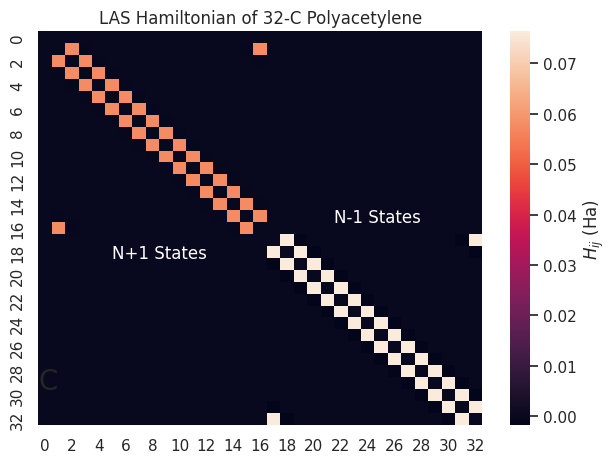

In [11]:
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=True)
H = las.make_h()
H = H - np.diag(np.diag(H))
sns.heatmap(H,cbar_kws={'label': "$H_{ij}$ (Ha)"})
plt.title("LAS Hamiltonian of 32-C Polyacetylene")
plt.annotate("N+1 States",(5.5,19),c="white")
plt.annotate("N-1 States",(22,16),c="white")
plt.annotate("C",(0,30),fontsize=20)
plt.tight_layout()
plt.savefig("figures/c32H_nodiag.png",dpi=500)

## Non-MC-PDFT

In [55]:
from tools.util import LASdata, DMRGdata, PeriodicData
import pandas as pd
df = pd.DataFrame()

per = PeriodicData("logs/periodic_HF_frag2C_24_k16.csv")
df.loc["HF (2C)","IP"] = per.ip()
df.loc["HF (2C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_PBE_frag2C_24_k16.csv")
df.loc["PBE (2C)","IP"] = per.ip()
df.loc["PBE (2C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_PBE_frag4C_24_k16.csv")
df.loc["PBE (4C)","IP"] = per.ip()
df.loc["PBE (4C)","EA"] = per.ea()
per = PeriodicData("logs/periodic_HSE06_frag2C_24_k16.csv")
df.loc["HSE06 (2C)","IP"] = per.ip()
df.loc["HSE06 (2C)","EA"] = per.ea()
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=False)
df.loc["LAS (2C)","IP"] = las.ip()
df.loc["LAS (2C)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/pa16_frag2_dist24_lsipdft.pkl",pdft=False)
df.loc["LAS (4C)","IP"] = las.ip()
df.loc["LAS (4C)","EA"] = las.ea()
las = LASdata(pkl_fn="logs/pa16_frag4_dist24_lsipdft.pkl",pdft=False)
df.loc["LAS (8C)","IP"] = las.ip()
df.loc["LAS (8C)","EA"] = las.ea()

def extrap(var,eight=False,plot=False):
    import matplotlib.pyplot as plt
    if eight:
        x = np.array([16/2,16/4,16/8]).reshape(-1, 1)
        y = df.loc[["LAS (2C)","LAS (4C)","LAS (8C)"],var]
    else:
        x = np.array([16/2,16/4]).reshape(-1, 1)
        y = df.loc[["LAS (2C)","LAS (4C)"],var]
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x,y)
    m, b = model.coef_, model.intercept_
    if plot:
        plt.scatter(x,y)
        x = np.arange(1,8,0.01)
        y = m*x + b
        plt.plot(x,y)
    return float(m+b)
df.loc["2-Pt. Extrap","IP"] = extrap("IP",eight=False)
df.loc["3-Pt. Extrap","IP"] = extrap("IP",eight=True)
df.loc["2-Pt. Extrap","EA"] = extrap("EA",eight=False)
df.loc["3-Pt. Extrap","EA"] = extrap("EA",eight=True)

dmrg = DMRGdata("logs/pa16_d24_m500.csv",pdft=False)
df.loc["DMRG (32C)","IP"] = dmrg.ip()
df.loc["DMRG (32C)","EA"] = dmrg.ea()
df.loc["BNL*","IP"] = 5.87
df.loc["BNL*","EA"] = -(-5.87 + 3.77)
df["GAP"] = df["IP"] - df["EA"]
df = df.T
df = np.round(df,2)
df

 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


,HF (2C),PBE (2C),PBE (4C),HSE06 (2C),LAS (2C),LAS (4C),LAS (8C),2-Pt. Extrap,3-Pt. Extrap,DMRG (32C),BNL*
IP,5.68,3.73,3.73,4.08,7.54,7.07,7.02,6.73,6.87,6.57,5.87
EA,-0.79,2.85,2.85,2.65,-3.17,-2.52,-2.40,-2.04,-2.21,-1.90,2.10
GAP,6.47,0.89,0.89,1.44,10.71,9.60,9.41,8.77,9.08,8.46,3.77


 0    1.730000e-16
 1    4.350000e-06
-1    4.370000e-06
Name: dw, dtype: float64


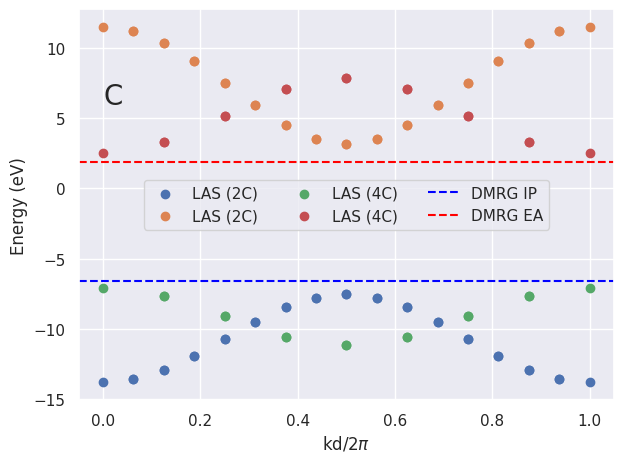

In [65]:
from tools.util import LASdata, DMRGdata, PeriodicData
las = LASdata(pkl_fn="logs/pa16_frag1_dist24_lsipdft.pkl",pdft=False)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS (2C)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS (2C)")

las = LASdata(pkl_fn="logs/pa16_frag2_dist24_lsipdft.pkl",pdft=False)
e,k = las.get_homo()
plt.scatter(k,e,label="LAS (4C)")
e,k = las.get_lumo()
plt.scatter(k,e,label="LAS (4C)")

dmrg = DMRGdata("logs/pa16_d24_m500.csv",pdft=False)
plt.axhline(dmrg.homo,linestyle="--",color="blue",label="DMRG IP")
plt.axhline(dmrg.lumo,linestyle="--",color="red",label="DMRG EA")

plt.legend(loc="center",ncols=3)

plt.ylabel("Energy (eV)")
plt.xlabel("kd/2$\pi$")
plt.annotate("C",(0,6),fontsize=20)
plt.tight_layout()
plt.savefig("figures/pa32c_las_band_structures.png",dpi=500)

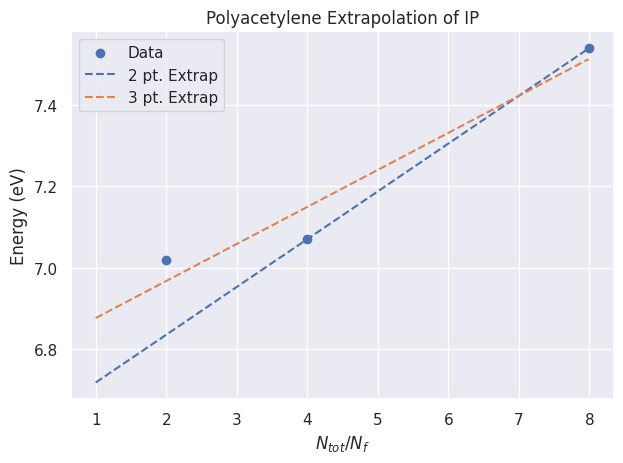

In [59]:
def plotfit(var):
    import matplotlib.pyplot as plt
    x0 = np.array([16/2,16/4,16/8]).reshape(-1, 1)
    y0 = df.loc[var,["LAS (2C)","LAS (4C)","LAS (8C)"]]
    plt.scatter(x0,y0,label="Data")
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x0[:2],y0[:2])
    x = np.arange(1,8,0.01)
    m,b = model.coef_, model.intercept_
    y = m*x + b
    plt.plot(x,y,label="2 pt. Extrap",linestyle="--")
    model.fit(x0,y0)
    m,b = model.coef_, model.intercept_
    y = m*x + b
    plt.plot(x,y,label="3 pt. Extrap",linestyle="--")
    plt.title(f"Polyacetylene Extrapolation of {var}")
    plt.ylabel("Energy (eV)")
    plt.xlabel("$N_{tot}/N_{f}$")
    plt.legend()
    plt.tight_layout()

plotfit("IP")
plt.savefig("figures/pa_ip_extrap.png",dpi=500)

In [56]:
print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  HF (2C) &  PBE (2C) &  PBE (4C) &  HSE06 (2C) &  LAS (2C) &  LAS (4C) &  LAS (8C) &  2-Pt. Extrap &  3-Pt. Extrap &  DMRG (32C) &  BNL* \\
\midrule
IP  &     5.68 &      3.73 &      3.73 &        4.08 &      7.54 &      7.07 &      7.02 &          6.73 &          6.87 &        6.57 &  5.87 \\
EA  &    -0.79 &      2.85 &      2.85 &        2.65 &     -3.17 &     -2.52 &     -2.40 &         -2.04 &         -2.21 &       -1.90 &  2.10 \\
GAP &     6.47 &      0.89 &      0.89 &        1.44 &     10.71 &      9.60 &      9.41 &          8.77 &          9.08 &        8.46 &  3.77 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1331882/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
